In [1]:
#libraries
import pandas as pd
import numpy as np
import sklearn
import warnings
warnings.filterwarnings('ignore')
#preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split,cross_val_score,StratifiedKFold,GridSearchCV,RandomizedSearchCV
from sklearn.decomposition import PCA
from imblearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

#metrics
from sklearn.metrics import roc_auc_score,plot_roc_curve,classification_report

#viz
import seaborn as sns
import matplotlib.pyplot as plt

#models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

#colors
custom_colors = ["#70D6FF","#FF70A6","#FF9770","#FFD670","#E9FF70"]

In [2]:
print (sklearn.__version__)

0.24.1


In [3]:
df_train = pd.read_csv(r"C:\Users\kevda\OneDrive\Desktop\data set\train.csv").drop('Id', axis=1)
df_test = pd.read_csv(r"C:\Users\kevda\OneDrive\Desktop\data set\test.csv").drop('Id', axis=1)
submission = pd.read_csv(r"C:\Users\kevda\OneDrive\Desktop\data set\sample_submission.csv")

In [4]:
print (df_train.columns)
print ('-------------------------------')
print (df_train.shape)
print ('-------------------------------')
print (df_train.isna().any().sum())
print ('-------------------------------')
print(df_train.dtypes.unique())

Index(['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1',
       'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4',
       'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5',
       'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10',
       'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14',
       'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18',
       'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22',
       'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26',
       'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30',
       'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34',
       'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38',
       'Soil_Type39', 'Soil_Type40

[1 2 3 6 7 4 5]
-------------------------------
2    2262087
1    1468136
3     195712
7      62261
6      11426
4        377
5          1
Name: Cover_Type, dtype: int64
-------------------------------
AxesSubplot(0.125,0.125;0.775x0.755)


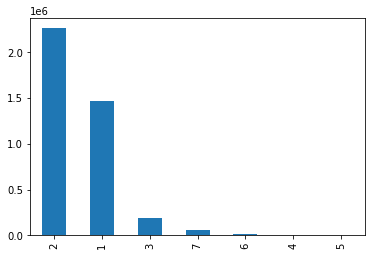

In [5]:
print (df_train['Cover_Type'].unique())
print ('-------------------------------')
print (df_train['Cover_Type'].value_counts())
print ('-------------------------------')
print (df_train['Cover_Type'].value_counts().plot(kind = 'bar'))

In [6]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))

In [7]:
start_mem = df_train.memory_usage().sum() / 1024**2
end_mem = df_train.memory_usage().sum() / 1024**2
print('Mem. usage to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
reduce_mem_usage(df_train)

Mem. usage to 1678.47 Mb (0.0% reduction)
Mem. usage decreased to 244.14 Mb (85.5% reduction)


In [8]:
for c in df_train.columns:
    if len(df_train[c].unique()) == 1:
        print(c)

Soil_Type7
Soil_Type15


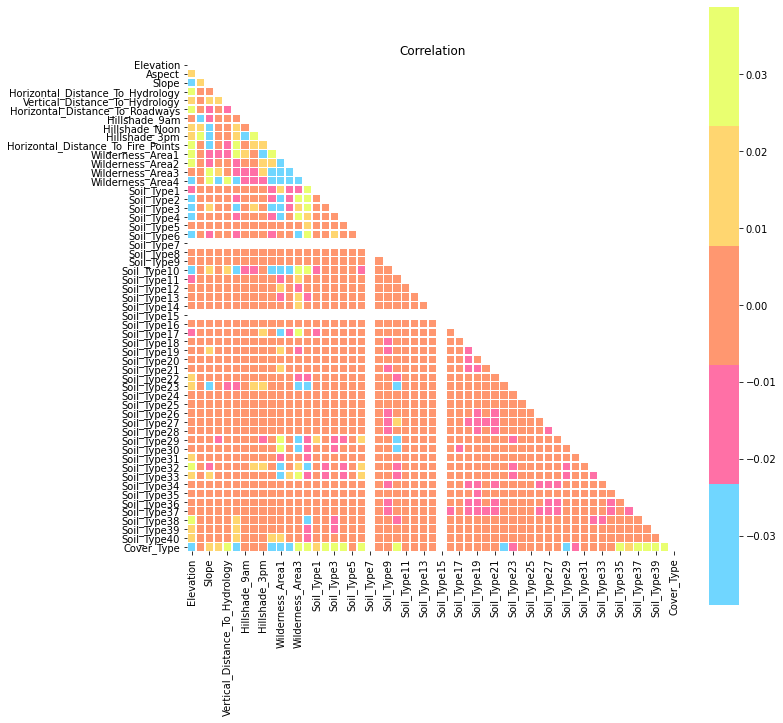

In [9]:
plt.figure(figsize = (11,11))
corr = df_train.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, cmap=custom_colors, robust=True, center=0,square=True, linewidths =.6)
plt.title('Correlation')
plt.show()

In [62]:
df = df_train.sample(frac=0.09, random_state=50)
df.shape

(360000, 55)

In [63]:
X = df.drop('Cover_Type', axis=1)
Y = df['Cover_Type']

In [64]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.02, random_state=50)

In [65]:
print (X_train.shape)
print (X_test.shape)

(352800, 54)
(7200, 54)


In [66]:
pipeNN = make_pipeline(StandardScaler(),
                       PCA(),
                     MLPClassifier()
                     )

In [67]:
pipeDt = make_pipeline(StandardScaler(),
                     PCA(),
                     DecisionTreeClassifier()
                     )

In [68]:
pipeRf = make_pipeline(StandardScaler(),
                     PCA(),
                     RandomForestClassifier()
                     )

In [69]:
pipeXgb = make_pipeline(StandardScaler(),
                     PCA(),
                     XGBClassifier()
                     )

In [70]:
pipelines = [pipeNN,pipeDt,pipeRf,pipeXgb]
pipe_map = {0:'NN',1:'Decision Tree',2:'RandomForest', 3:'XGB'}

In [71]:
best_accuracy=0.0
best_classifier=0
best_pipe=''

In [72]:
for pipe in pipelines:
    pipe.fit(X_train,Y_train)

[12:37:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [ ]:
for i,model in enumerate(pipelines):
    print ('{} test accuracy: {}'.format(pipe_map[i], model.score(X_test)*100))

In [73]:
Y_pred = pipeXgb.predict(X_test)

In [74]:
test_score = accuracy_score(Y_test, Y_pred)
print('Accuracy Score on test data set:', test_score)

Accuracy Score on test data set: 0.9238888888888889


In [75]:
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           1       0.90      0.93      0.92      2665
           2       0.95      0.94      0.94      4046
           3       0.89      0.85      0.87       351
           6       0.55      0.32      0.40        19
           7       0.67      0.61      0.64       119

    accuracy                           0.92      7200
   macro avg       0.79      0.73      0.75      7200
weighted avg       0.92      0.92      0.92      7200



In [76]:
submission['Cover_Type'] = pipeXgb.predict(df_test)

In [77]:
submission.head(5)

,Id,Cover_Type
0,4000000,2
1,4000001,2
2,4000002,2
3,4000003,2
4,4000004,2


In [78]:
submission.to_csv("submission6.csv", index=False)